In [12]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import os
import seaborn as sns
import category_encoders as ce

from sklearn.preprocessing import MinMaxScaler, Imputer
from xgboost import XGBClassifier, plot_importance
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,classification_report

In [2]:
print('\n'.join(os.listdir("data")))

bureau_balance.csv
Train_Eng2.csv
test_raw.csv
application_train.csv
train_raw.csv
new_train_raw.csv
bureau.csv
HomeCredit_columns_description.csv
credit_card_balance.csv
Train_Eng.csv
installments_payments.csv
POS_CASH_balance.csv
Test_Eng2.csv
sample_submission.csv
previous_application.csv
Test_Eng.csv
new_test_raw.csv
application_test.csv


In [2]:
train_eng = pd.read_csv('data/Train_Eng2.csv')
test_eng = pd.read_csv('data/Test_Eng2.csv')

In [3]:
print(train_eng.shape)
print(test_eng.shape)

(307511, 999)
(48744, 998)


In [3]:
train_label = train_eng['TARGET']

# What is our current feature ?

In [4]:
print("\n".join(sorted(train_eng.columns)))

1
AMT_ANNUITY
AMT_CREDIT
AMT_GOODS_PRICE
AMT_INCOME_TOTAL
AMT_REQ_CREDIT_BUREAU_DAY
AMT_REQ_CREDIT_BUREAU_HOUR
AMT_REQ_CREDIT_BUREAU_MON
AMT_REQ_CREDIT_BUREAU_QRT
AMT_REQ_CREDIT_BUREAU_WEEK
AMT_REQ_CREDIT_BUREAU_YEAR
ANNUITY_INCOME_PERCENT
APARTMENTS_AVG
APARTMENTS_MEDI
APARTMENTS_MODE
BASEMENTAREA_AVG
BASEMENTAREA_MEDI
BASEMENTAREA_MODE
CNT_CHILDREN
CNT_FAM_MEMBERS
CODE_GENDER
COMMONAREA_AVG
COMMONAREA_MEDI
COMMONAREA_MODE
CREDIT_INCOME_PERCENT
CREDIT_TERM
DAYS_BIRTH client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max
DAYS_BIRTH client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max client_credit_CNT_DRAWINGS_CURRENT_max_max
DAYS_BIRTH client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max^2
DAYS_BIRTH client_credit_CNT_DRAWINGS_CURRENT_max_max
DAYS_BIRTH client_credit_CNT_DRAWINGS_CURRENT_max_max^2
DAYS_BIRTH^2
DAYS_BIRTH^2 client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max
DAYS_BIRTH^2 client_credit_CNT_DRAWINGS_CURRENT_max_max
DAYS_BIRTH^3
DAYS_BIRTH_x
DAYS_BIRTH_y
DAYS_EMPLOYED
DAYS_EMPLOYED_ANOM
DAYS

# Clean Data again

## We have '1' column for what ?

In [5]:
train_eng.drop(columns = ['1'], inplace=True)
test_eng.drop(columns = ['1'], inplace=True)
print(train_eng.shape)
print(test_eng.shape)

(307511, 998)
(48744, 997)


## _x , _y is basically the same

In [6]:
dupcol = ['DAYS_BIRTH_y', 'EXT_SOURCE_1_y', 'EXT_SOURCE_2_y', 'EXT_SOURCE_3_y',\
 'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max_y', 'client_credit_CNT_DRAWINGS_CURRENT_max_max_y']

# df.rename(columns={'oldName1': 'newName1', 'oldName2': 'newName2'}, inplace=True)
train_eng.rename(inplace=True, columns={'DAYS_BIRTH_x': 'DAYS_BIRTH',
'EXT_SOURCE_1_x': 'EXT_SOURCE_1',
'EXT_SOURCE_2_x': 'EXT_SOURCE_2',
'EXT_SOURCE_3_x': 'EXT_SOURCE_3',
'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max_x': 'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max',
'client_credit_CNT_DRAWINGS_CURRENT_max_max_x': 'client_credit_CNT_DRAWINGS_CURRENT_max_max'})

test_eng.rename(inplace=True, columns={'DAYS_BIRTH_x': 'DAYS_BIRTH',
'EXT_SOURCE_1_x': 'EXT_SOURCE_1',
'EXT_SOURCE_2_x': 'EXT_SOURCE_2',
'EXT_SOURCE_3_x': 'EXT_SOURCE_3',
'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max_x': 'client_credit_CNT_DRAWINGS_ATM_CURRENT_mean_max',
'client_credit_CNT_DRAWINGS_CURRENT_max_max_x': 'client_credit_CNT_DRAWINGS_CURRENT_max_max'})

train_eng.drop(columns=dupcol, inplace=True)
test_eng.drop(columns=dupcol, inplace=True)

print(train_eng.shape)
print(test_eng.shape)

(307511, 992)
(48744, 991)


# What sould we have as a feature

* neighborstargetmean500: The mean TARGET value of the 500 closest neighbors of each row, where each neighborhood was defined by the three external sources and the credit/annuity ratio. 
* regionid: The REGIONIDPOPULATION field treated as a categorical rather than as a numeric feature. 
* debtcreditratioNone: grouped by SKIDCURR, the sum of all credit debt (AMTCREDITSUMDEBT) over the sum of all credit (AMCREDITSUM).
* creditannuityratio: AMTCREDIT / AMTANNUITY
* prevPRODUCTCOMBINATION: PRODUCTCOMBINATION value form most recent previous application. 
* DAYSCREDITmean: grouped by SKIDCURR, the mean CREDITDAYS value from the bureau table.
* creditgoodspriceratio: AMTCREDIT / AMTGOODSPRICE
* lastactiveDAYSCREDIT: From the active loans in bureau, the most recent DAYS CREDIT value, grouped by SKIDCURR. 
* creditdownpayment: AMTGOODPRICE - AMTCREDIT 
* AGEINT: int(DAYSBIRTH / -365) 
* installmentpaymentratio1000meanmean: Looking only at installment payments where DAYSINSTALLMENT>-1000, take the mean of AMTPAYMENT - AMTINSTALMENT, grouped first by SKIDPREV and then by SKIDCURR. 
* annuitytomaxinstallmentratio: AMTANNUITY / (maximum installment from the installmentspayments table, grouped by SKID_CURR).

### AMT_CREDIT_GOODS_PRICE_RATIO

In [7]:
train_eng['AMT_CREDIT_GOODS_PRICE_RATIO'] = train_eng['AMT_CREDIT'] / train_eng['AMT_GOODS_PRICE']
test_eng['AMT_CREDIT_GOODS_PRICE_RATIO'] = test_eng['AMT_CREDIT'] / test_eng['AMT_GOODS_PRICE']

### AMT_GOODS_MINUS_AMT_CREDIT

In [8]:
train_eng['AMT_GOODS_MINUS_AMT_CREDIT'] = train_eng['AMT_GOODS_PRICE'] - train_eng['AMT_CREDIT']
test_eng['AMT_GOODS_MINUS_AMT_CREDIT'] = test_eng['AMT_GOODS_PRICE'] - test_eng['AMT_CREDIT']

### AGE_YEAR

In [9]:
train_eng['AGE_YEAR'] = np.floor(train_eng['DAYS_BIRTH']/-365)
test_eng['AGE_YEAR'] = np.floor(test_eng['DAYS_BIRTH']/-365)
#train_eng['AGE_YEAR']

In [10]:
print(train_eng.shape)
print(test_eng.shape)

(307511, 995)
(48744, 994)


# Modeling

## deals with nan and scale

In [12]:
# Drop the target from the training data
if 'TARGET' in train_eng:
    train = train_eng.drop(columns = ['TARGET'])
else:
    train = train_eng.copy()
    
# Feature names
features = list(train.columns)

# Copy of the testing data
test = test_eng.copy()

# Median imputation of missing values
imputer = Imputer(strategy = 'median')

# Scale each feature to 0-1
scaler = MinMaxScaler(feature_range = (0, 1))

# Fit on the training data
imputer.fit(train)

# Transform both training and testing data
train = imputer.transform(train)
test = imputer.transform(test)

# Repeat with the scaler
scaler.fit(train)
train = scaler.transform(train)
test = scaler.transform(test)

print('Training data shape: ', train.shape)
print('Testing data shape: ', test.shape)

Training data shape:  (307511, 994)
Testing data shape:  (48744, 994)


## logistic linear regression

In [46]:
from sklearn.linear_model import LogisticRegression

# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train, train_label)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test)[:, 1]

# Submission dataframe
submit = test_eng[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

# Save the submission to a csv file
submit.to_csv('log_reg_All_table_new_FE2.csv', index = False)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


## PCA

In [13]:
from sklearn.decomposition import PCA
pca = PCA(n_components=994)
train_PCA = pca.fit_transform(train)
test_PCA = pca.transform(test)
print(train_PCA.shape)
print(test_PCA.shape)

(307511, 994)
(48744, 994)


#### logistic with PCA

In [48]:
# Make the model with the specified regularization parameter
log_reg = LogisticRegression(C = 0.0001)

# Train on the training data
log_reg.fit(train_PCA, train_label)

# Make predictions
# Make sure to select the second column only
log_reg_pred = log_reg.predict_proba(test_PCA)[:, 1]

# Submission dataframe
submit = test_eng[['SK_ID_CURR']]
submit['TARGET'] = log_reg_pred

# Save the submission to a csv file
submit.to_csv('log_reg_All_table_PCA_new_FE2.csv', index = False)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  del sys.path[0]


In [49]:
# from sklearn.model_selection import train_test_split
# X_train, X_test, Y_train, Y_test = train_test_split(train_PCA, train_label, test_size=0.2, random_state=42)

In [55]:
# del X_train
# del X_test
# del Y_train
# del Y_test

In [56]:
modelXGB = XGBClassifier(max_depth=6, learning_rate=0.1,n_estimators=100,
                      n_jobs=16,scale_pos_weight=4,missing=np.nan,gamma=16,
                      eval_metric="auc",reg_lambda=40,reg_alpha=40)
modelXGB.fit(train_PCA, train_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=16, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=16, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=40,
       reg_lambda=40, scale_pos_weight=4, seed=None, silent=True,
       subsample=1)

In [11]:
#try without fill nan
modelXGB = XGBClassifier(max_depth=6, learning_rate=0.1,n_estimators=100,
                      n_jobs=16,scale_pos_weight=4,missing=np.nan,gamma=16,
                      eval_metric="auc",reg_lambda=40,reg_alpha=40)
modelXGB.fit(train_eng.drop(columns=['TARGET']), train_label)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
       colsample_bytree=1, eval_metric='auc', gamma=16, learning_rate=0.1,
       max_delta_step=0, max_depth=6, min_child_weight=1, missing=None,
       n_estimators=100, n_jobs=16, nthread=None,
       objective='binary:logistic', random_state=0, reg_alpha=40,
       reg_lambda=40, scale_pos_weight=4, seed=None, silent=True,
       subsample=1)

In [ ]:
# from sklearn.metrics import roc_auc_score

# Y_train_predicted = modelXGB.predict_proba(X_train)[:,1]
# Y_test_predicted = modelXGB.predict_proba(X_test)[:,1]

# print("Train AUC %.4f" % roc_auc_score(Y_train, Y_train_predicted))
# print("Test AUC %.4f" % roc_auc_score(Y_test, Y_test_predicted))

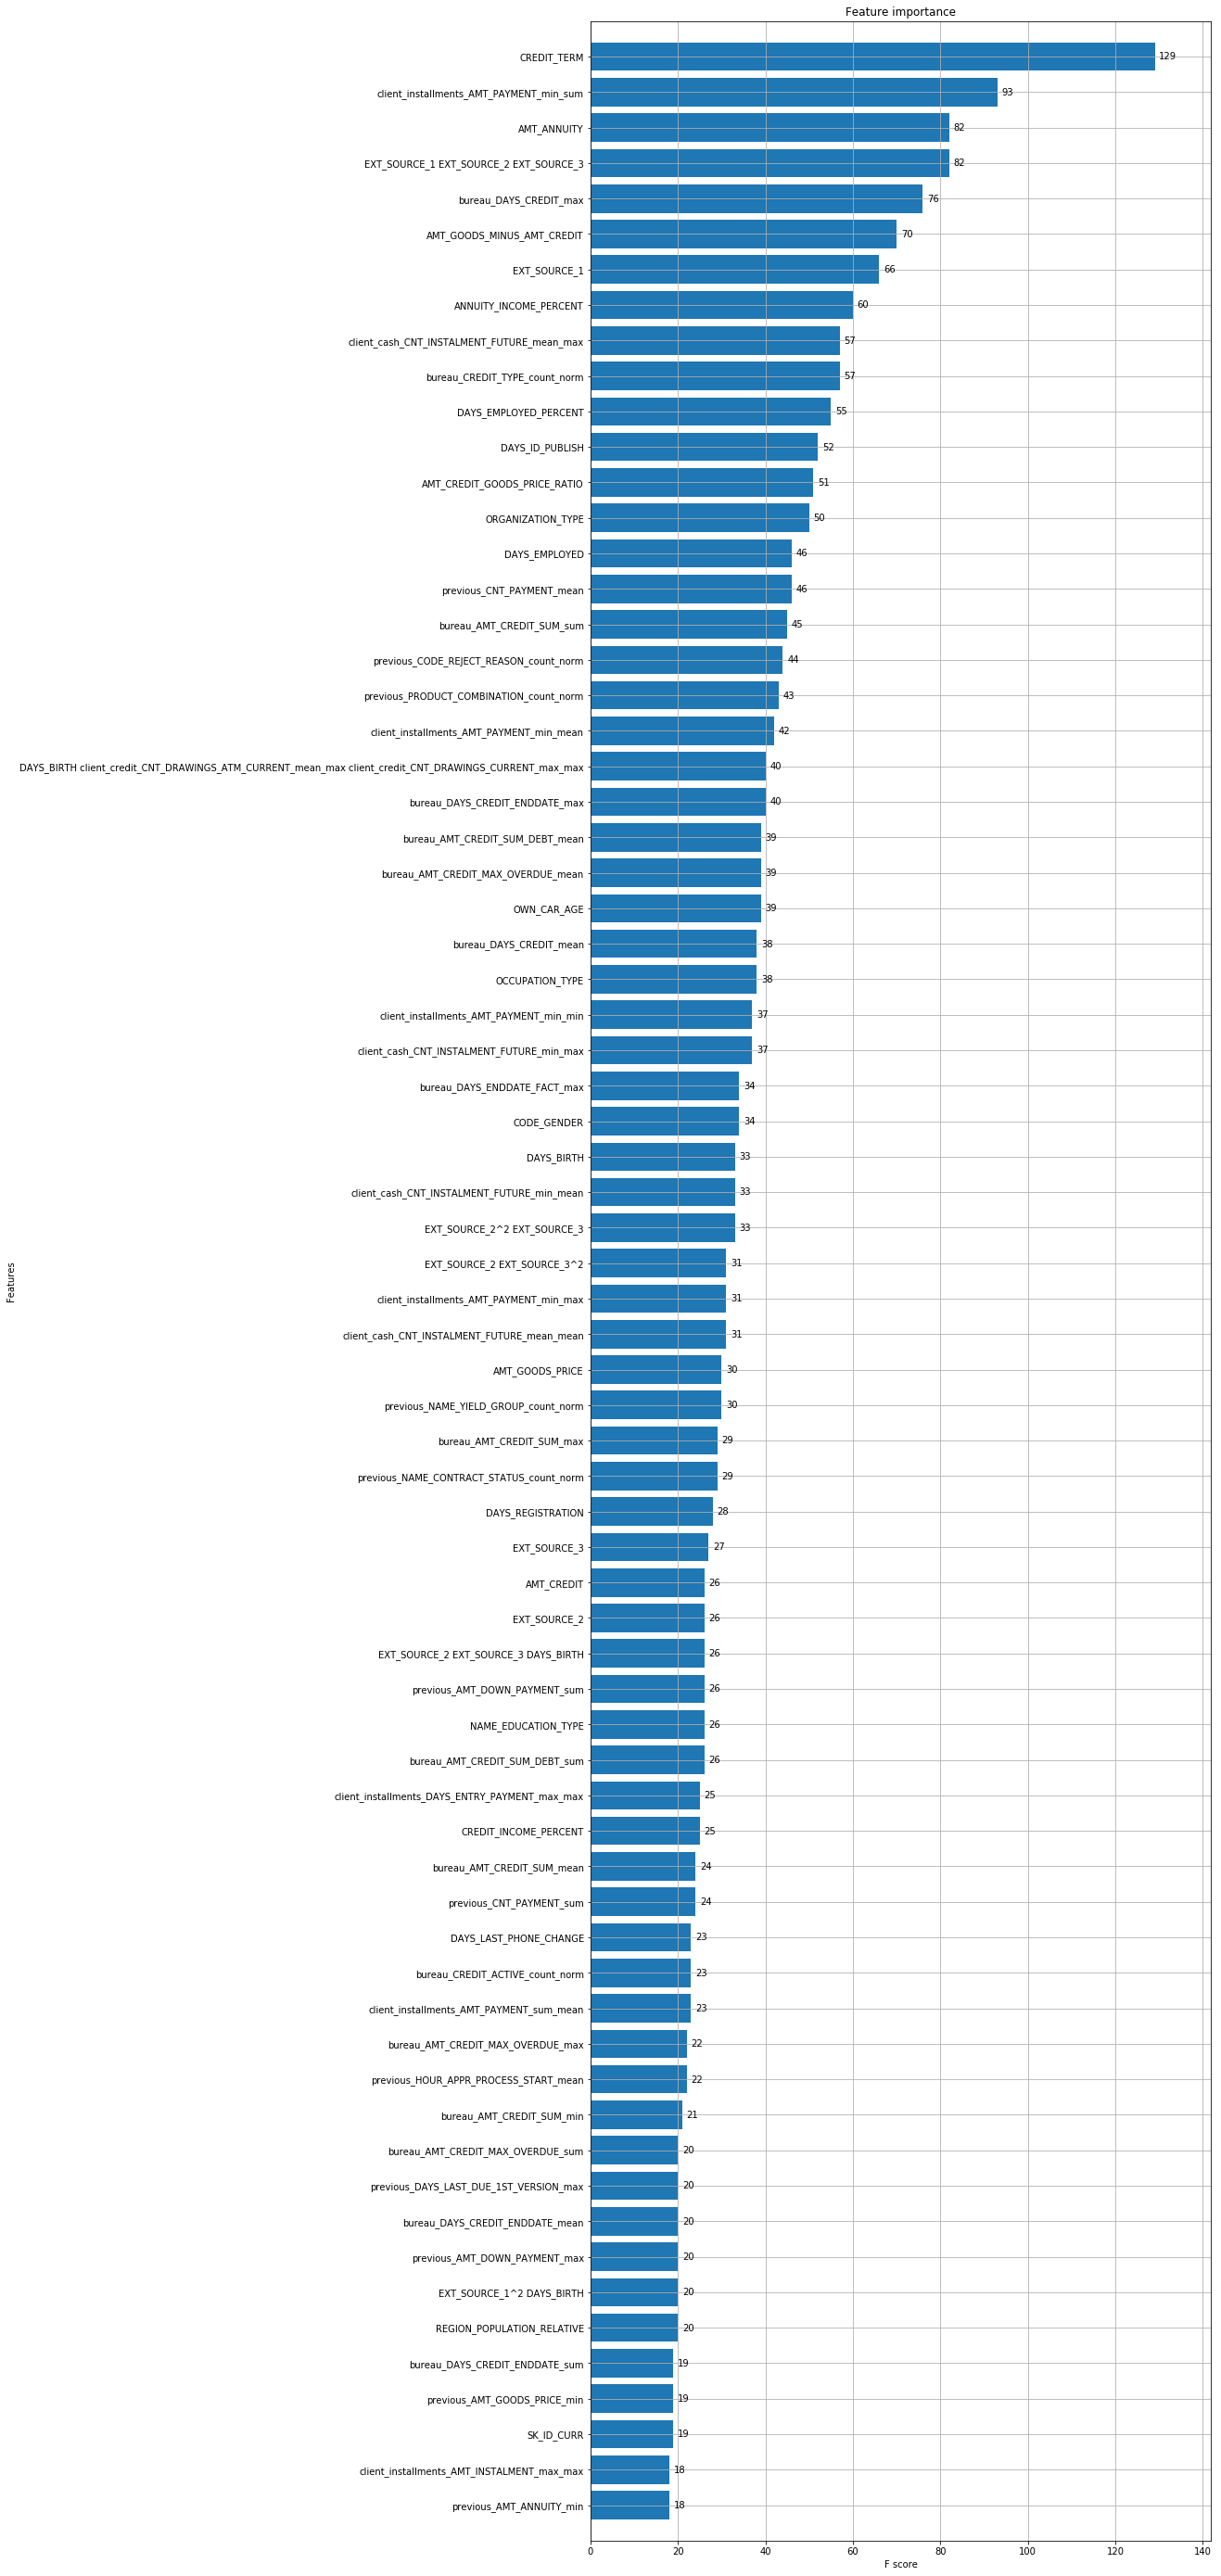

In [26]:
import xgboost
fig, ax = plt.subplots(figsize=(12,50))
plot_importance(modelXGB,max_num_features=70, height=0.8, ax=ax)
plt.show()

In [27]:
modelXGB_pred = modelXGB.predict_proba(test_eng)[:, 1]

# Submission dataframe
submit = test_eng[['SK_ID_CURR']]
submit['TARGET'] = modelXGB_pred

# Save the submission to a csv file
submit.to_csv('data/test_XGB_FE2_No_fillNaN2.csv', index=False)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [28]:
modelXGB_pred = modelXGB.predict_proba(train_eng.drop(columns=['TARGET']))[:, 1]

# Submission dataframe
submit = train_eng[['SK_ID_CURR']]
submit['TARGET'] = modelXGB_pred

# Save the submission to a csv file
submit.to_csv('data/train_XGB_FE2_No_fillNaN2.csv', index=False)

/usr/local/lib/python3.5/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  """


In [15]:
np.save('data/train_label', train_label)
np.save('data/train_PCA', train_PCA)
np.save('data/test_PCA', test_PCA)
np.save('data/train_eng', train_eng)
np.save('data/test_eng', test_eng)
#np.load('/tmp/123.npy')

In [16]:
# del train_PCA
# del test_PCA
# del train
# del test